In [1]:
import numpy as np
from numpy import log, sqrt
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [2]:
class BudgetPacingUCBCTR:
    def __init__(self, num_agents, budgets, valuations, epsilon, T, mu_bar, true_ctrs):
        """
        Inputs:
          num_agents: number of agents n
          budgets: list or array of budgets [B₁, ..., Bₙ]
          valuations: list or array of valuations [v₁, ..., vₙ]
          epsilon: pacing step-size (scalar for all agents)
          T: time horizon (number of rounds)
          mu_bar: upper bound on pacing multipliers
          true_ctrs: list or array of true CTRs [ρ₁, ..., ρₙ]
        """
        self.n = num_agents
        self.budgets = np.array(budgets, dtype=float)
        self.valuations = np.array(valuations, dtype=float)
        self.T = T
        self.epsilon = epsilon
        self.mu_bar = mu_bar
        self.true_ctrs = np.array(true_ctrs, dtype=float)

        self.mu = np.zeros(self.n)

        self.remaining_budget = self.budgets.copy()

        self.N = np.ones(self.n)  
        self.rho_hat = np.zeros(self.n)
        for k in range(self.n):

            click = np.random.rand() < self.true_ctrs[k]
            self.rho_hat[k] = 1.0 if click else 0.0

        self.allocations = np.zeros((self.n, T))  
        self.payments = np.zeros((self.n, T))       
        self.mu_history = np.zeros((self.n, T))       
        self.liquid_welfare = []  

    def run(self):
        for t in range(self.T):

            tilde_rho = self.rho_hat + sqrt(3 * log(self.T) / (2 * self.N))

            bids = np.zeros(self.n)
            for k in range(self.n):
                v_prime = self.valuations[k] * tilde_rho[k]
                bids[k] = min(v_prime / (1 + self.mu[k]), self.remaining_budget[k])

            effective_bids = tilde_rho * bids
            sorted_idx = np.argsort(effective_bids)[::-1]
            winner = sorted_idx[0]
            if len(sorted_idx) > 1:
                Q2 = effective_bids[sorted_idx[1]]
            else:
                Q2 = effective_bids[winner]

            z = np.zeros(self.n)
            for k in range(self.n):
                if k == winner:

                    clicked = (np.random.rand() < self.true_ctrs[k])
                    z[k] = (Q2 / tilde_rho[k]) if clicked else 0.0
                    self.N[k] += 1
                    self.rho_hat[k] = (1 - 1/self.N[k]) * self.rho_hat[k] + (1.0 if clicked else 0.0) / self.N[k]
                else:
                    z[k] = 0.0

            for k in range(self.n):
                update = self.mu[k] - self.epsilon * (self.budgets[k] / self.T - z[k])
                self.mu[k] = np.clip(update, 0, self.mu_bar)
                self.mu_history[k, t] = self.mu[k]
                self.remaining_budget[k] -= z[k]
                if self.remaining_budget[k] < 0:
                    self.remaining_budget[k] = 0.0
                if z[k] > 0:
                    self.allocations[k, t] = 1
                    self.payments[k, t] = z[k]

            lw = 0.0
            for k in range(self.n):
                impressions_allocated = np.sum(self.allocations[k, :t+1])
                value_k = impressions_allocated * (tilde_rho[k] * self.valuations[k])
                lw += min(self.budgets[k], value_k)
            self.liquid_welfare.append(lw)

        return self.allocations

    def compute_optimal_liquid_welfare(self):
        """
        Compute the optimal liquid welfare w*.
        We assume that if agent i is allocated x_i impressions,
        the expected value per impression is (rho_i * v_i),
        where rho_i is true CTR value for agent i.

        Returns:
          w_star: Optimal liquid welfare (gross expected value).
          x_opt:  Optimal impression allocations (per agent).
        """
        ctr = self.true_ctrs  
        valuations = self.valuations
        budgets = self.budgets
        T = self.T
        n = self.n

        value_per_impression = ctr * valuations
        c = -value_per_impression

        A_ub = []
        b_ub = []
        for i in range(n):
            constraint = np.zeros(n)
            constraint[i] = value_per_impression[i]
            A_ub.append(constraint)
            b_ub.append(budgets[i])
        A_ub.append(np.ones(n))
        b_ub.append(T)

        bounds = [(0, T) for _ in range(n)]
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        if result.success:
            x_opt = result.x
            w_star = -result.fun
            return w_star, x_opt
        else:
            raise Exception("Offline LP did not converge.")
        


    def calculate_OPT(self):
        """
        Calculate OPT (optimal revenue) according to equation (8)
        OPT = sum_{t=1}^T smax_{k∈[n]} ρ_k * v_{k,t}
        where smax denotes the second-highest value
        """
        T = self.T
        n = self.n
        opt_revenue = 0
        
        # For each round
        for t in range(T):
            # Calculate ρ_k * v_{k,t} for each agent
            products = self.true_ctrs * self.valuations
            # Get second highest value (smax)
            sorted_products = np.sort(products)[::-1]
            opt_revenue += sorted_products[1] if len(sorted_products) > 1 else sorted_products[0]
        
        return opt_revenue


    def calculate_theoretical_bound(self):
        """
        Calculate the RHS of inequality (10) in Theorem 1
        """
        n = self.n
        T = self.T
        c = 3  # exploration constant
        
        # Calculate K (upper bound on second highest ρ_k * v_{k,t})
        products = self.true_ctrs * self.valuations
        sorted_products = np.sort(products)[::-1]
        K = sorted_products[1] if len(sorted_products) > 1 else sorted_products[0]
        
        # First term: K * sum(sqrt(2c*T*log(2nT)/ρ_k))
        term1 = K * np.sum(np.sqrt(2 * c * self.T * np.log(2 * n * T) / self.true_ctrs))
        
        # Second term: K * μ̄ * sum(1/ε_k)
        term2 = K * self.mu_bar * np.sum(1/self.epsilon)
        
        # Third term: K/T
        term3 = K/T
        
        return term1 + term2 + term3

    def verify_theorem_1(self):
        """
        Verify Theorem 1 by comparing actual revenue regret with theoretical bound
        """
        # Calculate OPT (optimal revenue)
        opt = self.calculate_OPT()
        
        # Calculate actual revenue
        actual_rev = np.sum(self.payments)
        
        # Calculate actual regret
        actual_regret = opt - actual_rev
        
        # Calculate theoretical bound
        theoretical_bound = self.calculate_theoretical_bound()
        
        results = {
            'OPT': opt,
            'Actual Revenue': actual_rev,
            'Actual Regret': actual_regret,
            'Theoretical Bound': theoretical_bound,
            'Theorem Verified': actual_regret <= theoretical_bound
        }
        
        return results

In [4]:
num_agents = 3
budgets = [100, 150, 200]
valuations = [0.8, 0.7, 0.6]
epsilon = 0.025
T = 2500
mu_bar = 1.0
true_ctrs = [0.7, 0.50, 0.8]  

pacing_algo = BudgetPacingUCBCTR(num_agents, budgets, valuations, epsilon, T, mu_bar, true_ctrs)
allocations = pacing_algo.run()
print(pacing_algo.verify_theorem_1())

{'OPT': 1200.0000000000332, 'Actual Revenue': 395.6053265953077, 'Actual Regret': 804.3946734047255, 'Theoretical Bound': 698.70819508128, 'Theorem Verified': False}


Final CTR Estimates: [0.75193798 0.49868248 0.79779917]
Final Pacing Multipliers: [0. 0. 0.]
Remaining Budgets: [2.75047644e-04 3.83932443e+01 2.70977964e-02]
Achieved Liquid Welfare: 450.0
Offline Optimal Liquid Welfare: 450.0
Optimal Impression Allocations: [178.57142857 428.57142857 416.66666667]
Total Revenue: 411.5793828917988
Actual Revenue Regret: 38.42061710820121
Theoretical Regret Bound: 737.10819508128


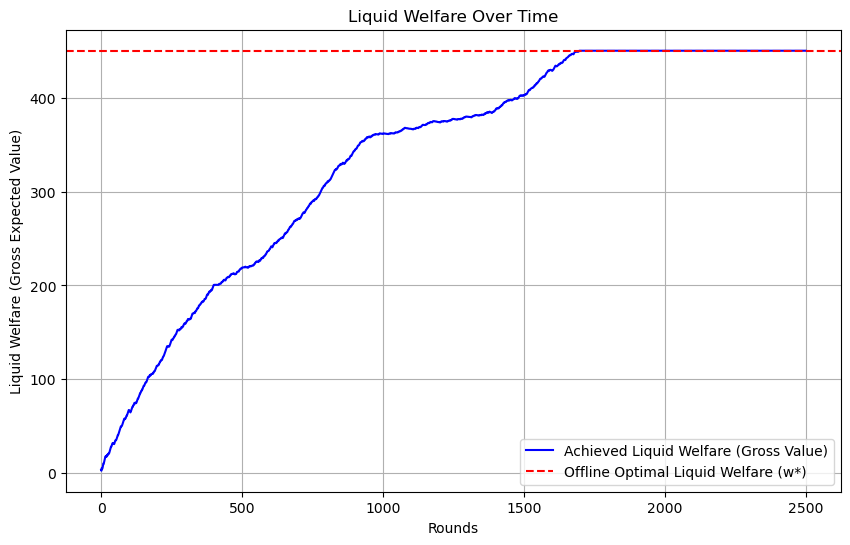

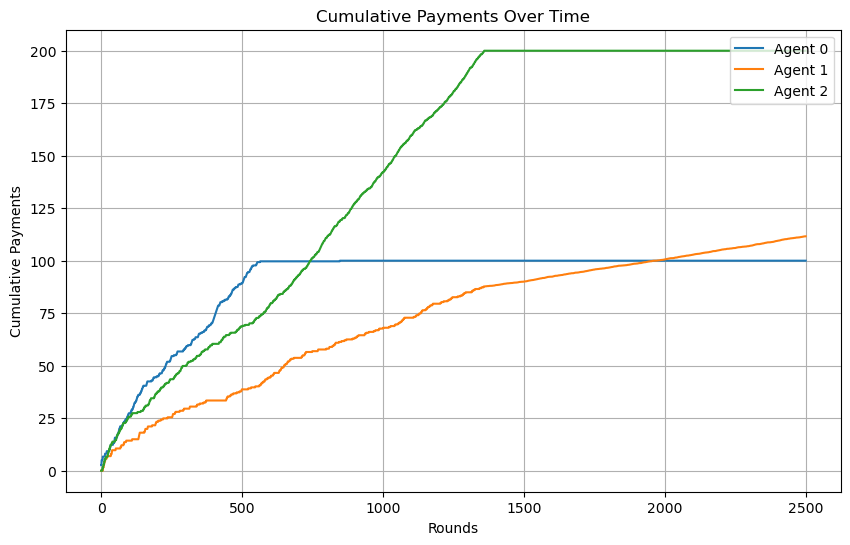

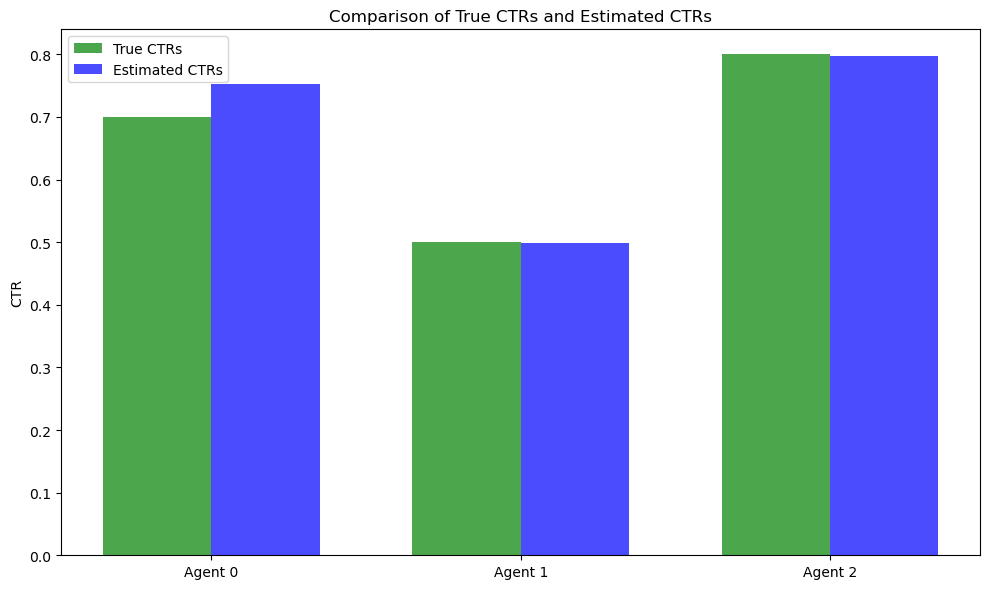

In [3]:
print("Final CTR Estimates:", pacing_algo.rho_hat)
print("Final Pacing Multipliers:", pacing_algo.mu)
print("Remaining Budgets:", pacing_algo.remaining_budget)

w_star, x_opt = pacing_algo.compute_optimal_liquid_welfare()
print("Achieved Liquid Welfare:", pacing_algo.liquid_welfare[-1])
print("Offline Optimal Liquid Welfare:", w_star)
print("Optimal Impression Allocations:", x_opt)

total_revenue = np.sum(pacing_algo.payments)
print("Total Revenue:", total_revenue)

actual_regret = w_star - total_revenue
print("Actual Revenue Regret:", actual_regret)

true_ctrs_arr = np.array(true_ctrs)
prod = true_ctrs_arr * np.array(valuations)
sorted_prod = np.sort(prod)

if num_agents >= 2:
    smax = sorted_prod[-2]
else:
    smax = sorted_prod[-1]
K = smax  

c = 3

term1 = 0.0
for k in range(num_agents):
    term1 += np.sqrt((2 * c * T * np.log(2 * num_agents * T)) / true_ctrs[k])

term2 = num_agents / epsilon

theoretical_bound = K * term1 + K * mu_bar * term2 + K / T
print("Theoretical Regret Bound:", theoretical_bound)

plt.figure(figsize=(10, 6))
plt.plot(range(len(pacing_algo.liquid_welfare)), pacing_algo.liquid_welfare, label="Achieved Liquid Welfare (Gross Value)", color="blue")
plt.axhline(y=w_star, color="red", linestyle="--", label="Offline Optimal Liquid Welfare (w*)")
plt.xlabel("Rounds")
plt.ylabel("Liquid Welfare (Gross Expected Value)")
plt.title("Liquid Welfare Over Time")
plt.legend()
plt.grid(True)
plt.savefig("liquid_welfare_over_time.png")
plt.show()

cumulative_payments = np.cumsum(pacing_algo.payments, axis=1)
plt.figure(figsize=(10, 6))
for agent in range(num_agents):
    plt.plot(cumulative_payments[agent], label=f"Agent {agent}")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Payments")
plt.title("Cumulative Payments Over Time")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("cumulative_payments_over_time.png")
plt.show()

labels = [f"Agent {i}" for i in range(num_agents)]
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_agents), true_ctrs, width, label="True CTRs", alpha=0.7, color="green")
plt.bar(np.arange(num_agents) + width, pacing_algo.rho_hat, width, label="Estimated CTRs", alpha=0.7, color="blue")
plt.xticks(np.arange(num_agents) + width/2, labels)
plt.ylabel("CTR")
plt.title("Comparison of True CTRs and Estimated CTRs")
plt.legend()
plt.tight_layout()
plt.savefig("true_vs_estimated_ctr.png")
plt.show()